# MLP FROM BASELINE WITH HYPERPARAMETER TUNING
 Goal: optimise Cox partial likelihood loss and maximise C-index score in validation.

Main changes:
LR sweep: controls stability and speed of convergence
    - too high: loss unstable, C-index fluctuates
    - too low: undertraining, slow plateau

In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix
) 

import tensorflow as tf
from tensorflow import keras
from keras import layers


RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Charger les X_train/ X_test…

In [107]:
X_train = np.load("./tcga_brca_qc_report/X_train_z.npy")
X_test  = np.load("./tcga_brca_qc_report/X_test_z.npy")

# tf/keras: float32 recommandé
X_train = np.asarray(X_train, dtype=np.float32)
X_test  = np.asarray(X_test, dtype=np.float32)

print("X_train:", X_train.shape, X_train.dtype)
print("X_test :", X_test.shape,  X_test.dtype)

X_train: (814, 10000) float32
X_test : (208, 10000) float32


# Charger les méta et définir les colonnes de survie

In [108]:
""" temps: days_to_last follow_up or days_to_death
event: vital_status (dead or alive)
"""

meta_tr = pd.read_csv("./tcga_brca_qc_report/meta_train_postQC.csv")
meta_te = pd.read_csv("./tcga_brca_qc_report/meta_test_postQC.csv")

# 
# temps (en jours) et event (dead or alive)
TIME_COL = "days_to_last_follow_up"    # car days_to_death a bcp trop de NaN
EVENT_COL = "vital_status"  

if TIME_COL not in meta_tr.columns or EVENT_COL not in meta_tr.columns:
    raise ValueError(
        f"TIME_COL/EVENT_COL non trouvées dans meta.\n"
        f"Colonnes meta_tr (extrait): {meta_tr.columns.tolist()[:40]}"
    )

t_train = pd.to_numeric(meta_tr[TIME_COL], errors="coerce").values
e_train = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce").values

t_test  = pd.to_numeric(meta_te[TIME_COL], errors="coerce").values
e_test  = pd.to_numeric(meta_te[EVENT_COL], errors="coerce").values

print("Survival train:", np.nanmin(t_train), np.nanmax(t_train), "events:", np.nansum(e_train))
print("Survival test :", np.nanmin(t_test),  np.nanmax(t_test),  "events:", np.nansum(e_test))

Survival train: -7.0 8605.0 events: 0.0
Survival test : 0.0 5156.0 events: 0.0


## Standardiser vital_status et création de event (CoX°)

In [109]:
def standardize_vital_status(series):
    s = series.copy()

    # Cas numérique (0/1)
    s_num = pd.to_numeric(s, errors="coerce")
    vals = set(s_num.dropna().unique().tolist())
    if len(vals) > 0 and vals.issubset({0.0, 1.0}):
        return s_num

    # Cas texte ("Alive"/"Dead")
    s_txt = s.astype(str).str.strip().str.lower()
    return s_txt.map({"alive": 1, "dead": 0})


meta_tr["vital_status"] = standardize_vital_status(meta_tr["vital_status"])
meta_te["vital_status"] = standardize_vital_status(meta_te["vital_status"])

# Convention Cox : event = 1 si décès
meta_tr["event"] = 1 - meta_tr["vital_status"]
meta_te["event"] = 1 - meta_te["vital_status"]

print("vital_status train:")
print(meta_tr["vital_status"].value_counts(dropna=False))
print("vital_status test:")
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status train:
vital_status
1.0    694
0.0    119
NaN      1
Name: count, dtype: int64
vital_status test:
vital_status
1    186
0     22
Name: count, dtype: int64


# Refaire l'alignement

In [110]:
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

time_tr  = pd.to_numeric(meta_tr[TIME_COL], errors="coerce")
event_tr = pd.to_numeric(meta_tr[EVENT_COL], errors="coerce")

mask_tr = time_tr.notna() & (time_tr > 0) & event_tr.notna() & event_tr.isin([0, 1])

X_train = X_train[mask_tr.values]
meta_tr = meta_tr.loc[mask_tr].reset_index(drop=True)

time_te  = pd.to_numeric(meta_te[TIME_COL], errors="coerce")
event_te = pd.to_numeric(meta_te[EVENT_COL], errors="coerce")

mask_te = time_te.notna() & (time_te > 0) & event_te.notna() & event_te.isin([0, 1])

X_test = X_test[mask_te.values]
meta_te = meta_te.loc[mask_te].reset_index(drop=True)

print("Aligned train:", X_train.shape, meta_tr.shape)
print("Aligned test :", X_test.shape, meta_te.shape)

Aligned train: (795, 10000) (795, 91)
Aligned test : (206, 10000) (206, 91)


In [111]:
# Recréer t_test / e_test APRÈS alignement (sinon peut avoir mismatch)
# ============================================================

t_test = meta_te[TIME_COL].astype(np.float32).values
e_test = meta_te[EVENT_COL].astype(np.float32).values  # EVENT_COL = "event"

print("Shapes check -> X_test:", X_test.shape, " t_test:", t_test.shape, " e_test:", e_test.shape)

Shapes check -> X_test: (206, 10000)  t_test: (206,)  e_test: (206,)


In [112]:
# verifie le nombre de alive et dead après le mapping
print(meta_tr["vital_status"].value_counts(dropna=False))
print(meta_te["vital_status"].value_counts(dropna=False))

vital_status
1.0    678
0.0    117
Name: count, dtype: int64
vital_status
1    184
0     22
Name: count, dtype: int64


# Checker les NaN

In [113]:
# Check combien de NaN dans event et time restent et si event est bien en binaire
print("NaN event train:", meta_tr["event"].isna().sum())
print("NaN event test :", meta_te["event"].isna().sum())

print("Unique event train:", meta_tr["event"].dropna().unique()[:10])
print("Unique event test :", meta_te["event"].dropna().unique()[:10])

print("NaN time train:", meta_tr["days_to_last_follow_up"].isna().sum())
print("NaN time test :", meta_te["days_to_last_follow_up"].isna().sum())

NaN event train: 0
NaN event test : 0
Unique event train: [0. 1.]
Unique event test : [0 1]
NaN time train: 0
NaN time test : 0


In [114]:
assert meta_tr["event"].isna().sum() == 0
assert meta_te["event"].isna().sum() == 0
assert (meta_tr["days_to_last_follow_up"] > 0).all()
assert (meta_te["days_to_last_follow_up"] > 0).all()

print("Survival data clean and aligned ✔")

Survival data clean and aligned ✔


# Split intern /validation

In [115]:
val_frac = 0.15

n = X_train.shape[0]
idx = np.arange(n)
np.random.default_rng(RANDOM_STATE).shuffle(idx)

n_val = int(val_frac * n)
val_idx = idx[:n_val]
tr_idx  = idx[n_val:]

X_tr  = X_train[tr_idx]
X_val = X_train[val_idx]

t_tr  = meta_tr.iloc[tr_idx]["days_to_last_follow_up"].astype(np.float32).values
t_val = meta_tr.iloc[val_idx]["days_to_last_follow_up"].astype(np.float32).values

e_tr  = meta_tr.iloc[tr_idx]["event"].astype(np.float32).values
e_val = meta_tr.iloc[val_idx]["event"].astype(np.float32).values

print("Train:", X_tr.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)
print("Event rate (train):", e_tr.mean())

Train: (676, 10000)
Val  : (119, 10000)
Test : (206, 10000)
Event rate (train): 0.147929


# Loss Cox partial likelihood

In [116]:
def cox_ph_loss(t, e, r, eps=1e-8):
    # shapes
    t = tf.reshape(tf.cast(t, tf.float32), [-1])
    e = tf.reshape(tf.cast(e, tf.float32), [-1])
    r = tf.reshape(tf.cast(r, tf.float32), [-1])

    # sort by descending time
    order = tf.argsort(t, direction="DESCENDING")
    e = tf.gather(e, order)
    r = tf.gather(r, order)

    # numeric stabilization: subtract max before exp, then add it back
    r_max = tf.reduce_max(r)
    r_stab = r - r_max

    # log(sum_{j in risk set} exp(r_j)) via log(cumsum(exp(.)))
    log_cum_sum_exp = tf.math.log(tf.cumsum(tf.exp(r_stab)) + eps) + r_max

    pll = tf.reduce_sum(e * (r - log_cum_sum_exp))
    n_events = tf.reduce_sum(e) + eps
    return -pll / n_events

# Sanity check

In [117]:
def _check_shapes(X, t, e, name):
    assert X.shape[0] == len(t) == len(e), f"{name}: mismatch shapes"
    assert np.isfinite(X).all(), f"{name}: X has NaN/inf"
    assert np.isfinite(t).all(), f"{name}: t has NaN/inf"
    assert np.isfinite(e).all(), f"{name}: e has NaN/inf"
    # e doit être binaire {0,1}
    u = set(np.unique(e).tolist())
    assert u.issubset({0.0, 1.0, 0, 1}), f"{name}: e not binary, got {u}"

_check_shapes(X_tr, t_tr, e_tr, "train")
_check_shapes(X_val, t_val, e_val, "val")
_check_shapes(X_test, t_test, e_test, "test")

print("Event rate train:", float(np.mean(e_tr)))
print("Event rate val  :", float(np.mean(e_val)))
print("Event rate test :", float(np.mean(e_test)))

Event rate train: 0.14792899787425995
Event rate val  : 0.1428571492433548
Event rate test : 0.10679611563682556


# Cox loss + C index

In [118]:
def cox_ph_loss(t, e, r, eps=1e-8):
    """
    Negative partial log-likelihood (Breslow) averaged over #events.
    t: times (float)
    e: events (0/1)
    r: risk scores (real-valued), shape (n,1) or (n,)
    """
    t = tf.reshape(t, [-1])
    e = tf.reshape(e, [-1])
    r = tf.reshape(r, [-1])

    # sort by descending time
    order = tf.argsort(t, direction="DESCENDING")
    e = tf.gather(e, order)
    r = tf.gather(r, order)

    # stabilization for exp/log
    r_max = tf.reduce_max(r)
    r_stab = r - r_max

    log_cum_sum_exp = tf.math.log(tf.cumsum(tf.exp(r_stab)) + eps) + r_max
    pll = tf.reduce_sum(e * (r - log_cum_sum_exp))
    n_events = tf.reduce_sum(e) + eps
    return -pll / n_events


def harrell_c_index(t, e, risk):
    """
    Harrell's C-index (numpy).
    risk: higher = higher risk (worse prognosis)
    """
    t = np.asarray(t).reshape(-1)
    e = np.asarray(e).reshape(-1)
    risk = np.asarray(risk).reshape(-1)

    concordant = 0.0
    permissible = 0.0
    ties = 0.0

    n = len(t)
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] <= t[i]:
                continue
            permissible += 1
            if risk[i] > risk[j]:
                concordant += 1
            elif risk[i] == risk[j]:
                ties += 1

    if permissible == 0:
        return np.nan
    return (concordant + 0.5 * ties) / permissible

# Builder MLP

In [119]:
def build_mlp(n_features, hidden=(128, 64), dropout=0.2):
    inputs = keras.Input(shape=(n_features,))
    x = inputs
    for h in hidden:
        x = layers.Dense(h, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
    risk = layers.Dense(1, activation=None)(x)
    return keras.Model(inputs, risk, name="MLP_Cox")

# Entraînements, early stopping sur C index val

In [120]:
def train_one_run(
    X_tr, t_tr, e_tr,
    X_val, t_val, e_val,
    lr=1e-3,
    batch_size=128,
    epochs=200,
    patience=20,
    hidden=(128, 64),
    dropout=0.2,
    verbose=0
):
    n_features = X_tr.shape[1]
    model = build_mlp(n_features, hidden=hidden, dropout=dropout)
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    # tf.data
    ds_tr = tf.data.Dataset.from_tensor_slices(
        (X_tr.astype(np.float32), t_tr.astype(np.float32), e_tr.astype(np.float32))
    ).shuffle(len(X_tr), seed=RANDOM_STATE).batch(batch_size)

    # history
    hist = []
    best = {"epoch": None, "val_cindex": -np.inf, "weights": None}

    wait = 0
    for ep in range(1, epochs + 1):
        # ---- train
        tr_losses = []
        for xb, tb, eb in ds_tr:
            with tf.GradientTape() as tape:
                rb = model(xb, training=True)
                loss = cox_ph_loss(tb, eb, rb)
            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))
            tr_losses.append(float(loss.numpy()))
        tr_loss = float(np.mean(tr_losses))

        # ---- val
        r_val = model(X_val.astype(np.float32), training=False).numpy().reshape(-1)
        val_loss = float(cox_ph_loss(
            tf.constant(t_val.astype(np.float32)),
            tf.constant(e_val.astype(np.float32)),
            tf.constant(r_val.astype(np.float32))
        ).numpy())
        val_c = float(harrell_c_index(t_val, e_val, r_val))

        hist.append({"epoch": ep, "train_loss": tr_loss, "val_loss": val_loss, "val_cindex": val_c, "lr": lr})

        # ---- early stopping on val_cindex
        improved = (val_c > best["val_cindex"])
        if improved:
            best.update({"epoch": ep, "val_cindex": val_c, "weights": model.get_weights()})
            wait = 0
        else:
            wait += 1

        if verbose and (ep % 10 == 0 or ep == 1):
            print(f"ep={ep:03d} tr_loss={tr_loss:.4f} val_loss={val_loss:.4f} val_c={val_c:.4f} (best {best['val_cindex']:.4f})")

        if wait >= patience:
            break

    # restore best
    if best["weights"] is not None:
        model.set_weights(best["weights"])

    df_hist = pd.DataFrame(hist)
    return model, df_hist, best

# Grid search sur LR (LR sweep)

In [121]:
lr_grid = [1e-4, 3e-4, 1e-3, 3e-3]  

runs = []
best_models = {}
hist_by_lr = {}  

for lr in lr_grid:
    model, df_hist, best = train_one_run(
        X_tr, t_tr, e_tr,
        X_val, t_val, e_val,
        lr=lr,
        batch_size=128,
        epochs=200,
        patience=20,
        hidden=(128, 64),
        dropout=0.2,
        verbose=0
    )

    row = {
        "lr": lr,
        "best_epoch": best["epoch"],
        "best_val_cindex": best["val_cindex"],
        "final_epoch_ran": int(df_hist["epoch"].max()),
        "final_val_cindex": float(df_hist.iloc[-1]["val_cindex"]),
    }
    runs.append(row)

    best_models[lr] = model
    hist_by_lr[lr] = df_hist    # <-- AJOUT: sauvegarde l'historique de ce LR

df_runs = pd.DataFrame(runs).sort_values("best_val_cindex", ascending=False)
df_runs

2026-02-03 01:14:22.788714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:23.091831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:23.705026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:24.167824: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:24.563747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:24.891707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 01:14:25.211395: W tensorflow/core/framework/local_rendezvous.cc:404] L

,lr,best_epoch,best_val_cindex,final_epoch_ran,final_val_cindex
1,0.0003,36,0.843216,56,0.675377
0,0.0001,62,0.792965,82,0.757789
2,0.0010,26,0.723618,46,0.598995
3,0.0030,1,0.659296,21,0.544724


# Evaluer le meilleur LR sur le test

In [122]:
best_lr = float(df_runs.iloc[0]["lr"])
best_model = best_models[best_lr]

r_test = best_model(X_test.astype(np.float32), training=False).numpy().reshape(-1)
test_c = float(harrell_c_index(t_test, e_test, r_test))

print("Best LR:", best_lr)
print("Test C-index:", test_c)
print("r_test shape:", r_test.shape)
print("meta_te shape:", meta_te.shape)

best_hist = hist_by_lr[best_lr]
best_epoch = int(df_runs.iloc[0]["best_epoch"])

Best LR: 0.0003
Test C-index: 0.5831240582621798
r_test shape: (206,)
meta_te shape: (206, 91)


# Graphique de la Cox loss sur meilleur LR

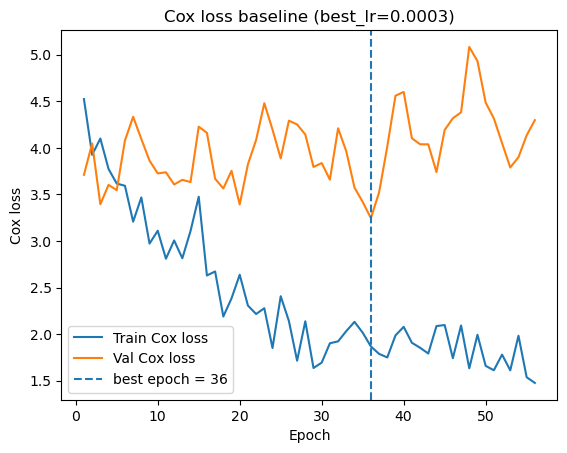

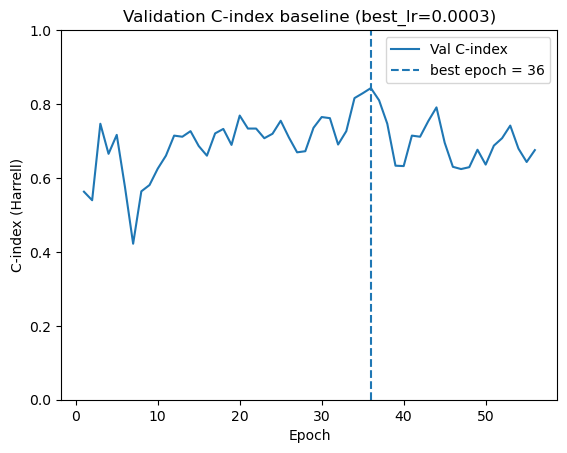

In [123]:
# ---- Figure 1: Cox loss curves (best_lr) ----
plt.figure()
plt.plot(best_hist["epoch"], best_hist["train_loss"], label="Train Cox loss")
plt.plot(best_hist["epoch"], best_hist["val_loss"], label="Val Cox loss")
plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")
plt.xlabel("Epoch")
plt.ylabel("Cox loss")
plt.title(f"Cox loss baseline (best_lr={best_lr:g})")
plt.legend()
plt.show()

# ---- Figure 2: Validation C-index over epochs (best_lr) ----
plt.figure()
plt.plot(best_hist["epoch"], best_hist["val_cindex"], label="Val C-index")
plt.axvline(best_epoch, linestyle="--", label=f"best epoch = {best_epoch}")# Export des données pour analyse biologique
plt.xlabel("Epoch")
plt.ylabel("C-index (Harrell)")
plt.ylim(0, 1)
plt.title(f"Validation C-index baseline (best_lr={best_lr:g})")
plt.legend()
plt.show()

In [124]:
def harrell_c_index(t, e, risk):
    n = len(t)
    num = 0.0
    den = 0.0
    for i in range(n):
        if e[i] != 1:
            continue
        for j in range(n):
            if t[j] > t[i]:
                den += 1
                if risk[i] > risk[j]:
                    num += 1
                elif risk[i] == risk[j]:
                    num += 0.5
    return num / den if den > 0 else np.nan

# Charger le meilleur modèle sauvegardé
best = keras.models.load_model("best_mlp_cox.keras", compile=False)

# Prédiction du score de risque
risk_test = r_test

# Variables de survie
t_test = meta_te["days_to_last_follow_up"].astype(np.float32).values
e_test = meta_te["event"].astype(np.float32).values

# C-index
cidx = harrell_c_index(t_test, e_test, risk_test)
print("Test C-index (MLP baseline):", cidx)

Test C-index (MLP baseline): 0.5831240582621798


# Export des données pour analyse biologique

In [125]:
# ============================================================
# Export des risk scores — MLP BASELINE (TEST uniquement)
# ============================================================

import os
import numpy as np
import pandas as pd

EXPORT_DIR = "./results_risk"
os.makedirs(EXPORT_DIR, exist_ok=True)

RUN_NAME = "MLP_BASELINE_LR_SWEEP"
ID_COL = "submitter_id"
TIME_COL = "days_to_last_follow_up"
EVENT_COL = "event"

df_test = pd.DataFrame({
    ID_COL: meta_te[ID_COL].astype(str).values,
    "split": "test",
    "risk_score": np.asarray(r_test).reshape(-1),
    "time": meta_te[TIME_COL].astype(float).values,
    "event": meta_te[EVENT_COL].astype(int).values
})

out_path = os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_test.csv")
df_test.to_csv(out_path, index=False)

# optionnel : risk_all = risk_test (cohérence avec les autres runs)
df_test.to_csv(os.path.join(EXPORT_DIR, f"{RUN_NAME}_risk_all.csv"), index=False)

print("Saved:", out_path)

Saved: ./results_risk/MLP_BASELINE_LR_SWEEP_risk_test.csv


# GO enrichment

In [126]:
# GO ENRICHMENT
# Ce code utilise directement les variables déjà présentes dans le notebook

import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

# ------------------------------------------------------------
# Configuration

RUN_NAME = "MLP_BASELINE_LR_SWEEP"  #a changer selon notebook

OUTDIR = f"./interpretation_{RUN_NAME}"
os.makedirs(OUTDIR, exist_ok=True)

TOP_N = 300  # Nombre de top gènes
DO_GO = True  

# ------------------------------------------------------------
# 1. Charger les gene names (depuis ton QC)
#

gene_names_path = "./tcga_brca_qc_report/gene_names.npy"

if not os.path.exists(gene_names_path):
    print(f"  Gene names file not found: {gene_names_path}")
    print("Creating gene_names from column names...")
    # Si le fichier n'existe pas, tu peux le créer une fois à partir d'un CSV
    # ou utiliser un placeholder
    gene_names = [f"GENE_{i}" for i in range(X_test.shape[1])]
else:
    gene_names = np.load(gene_names_path, allow_pickle=True).astype(str)

print(f"✓ Loaded {len(gene_names)} gene names")

# ------------------------------------------------------------
# 2. Variables déjà présentes dans le notebook
#
# X_test : déjà chargé (shape: n_samples × n_genes)
# risk_test : déjà calculé par le MLP (shape: n_samples,)
# meta_te : déjà chargé (contient submitter_id)

print(f"✓ X_test shape: {X_test.shape}")
print(f"✓ Risk scores: {len(risk_test)}")
print(f"✓ Meta test: {len(meta_te)}")

# Récupérer les sample IDs
sample_ids = meta_te["submitter_id"].astype(str).values

# -----------------------------------------------------------
# 3. Créer le DataFrame d'expression
#
expr_df = pd.DataFrame(
    X_test,
    index=sample_ids,
    columns=gene_names
)

# --------------------------------------------------------------
# 4. Calculer corrélation Spearman : expression envrion égalle au risk_score
#
print("\n" + "="*60)
print("Calculating gene-risk correlations...")
print("="*60)

rows = []
for i, gene in enumerate(gene_names):
    if i % 1000 == 0:
        print(f"  Progress: {i}/{len(gene_names)} genes...")
    
    gene_expr = expr_df[gene].values
    r, pval = spearmanr(gene_expr, risk_test)
    rows.append((gene, r, pval))

rank_df = pd.DataFrame(rows, columns=["gene", "spearman_r", "pvalue"])
rank_df["abs_r"] = rank_df["spearman_r"].abs()
rank_df["qvalue"] = multipletests(rank_df["pvalue"].values, method="fdr_bh")[1]
rank_df = rank_df.sort_values("abs_r", ascending=False).reset_index(drop=True)

# Sauvegarder le ranking complet
out_rank = os.path.join(OUTDIR, "gene_risk_correlation.csv")
rank_df.to_csv(out_rank, index=False)
print(f"\n✓ Saved full gene ranking: {out_rank}")

# ------------------------------------------------------------
# 5. Top gènes
#
top_genes = rank_df["gene"].head(TOP_N).tolist()
out_top = os.path.join(OUTDIR, f"top_{TOP_N}_genes.txt")
with open(out_top, "w") as f:
    f.write("\n".join(top_genes))

print(f"✓ Saved top {TOP_N} genes: {out_top}")

# Afficher top 10
print(f"\nTop 10 genes correlated with {RUN_NAME} risk score:")
print(f"{'Rank':<6} {'Gene':<15} {'Spearman r':<12} {'P-value':<12} {'Q-value':<12}")
print("-" * 60)
for i, gene in enumerate(top_genes[:10], 1):
    row = rank_df[rank_df["gene"] == gene].iloc[0]
    print(f"{i:<6} {gene:<15} {row['spearman_r']:>+10.4f}  {row['pvalue']:>10.2e}  {row['qvalue']:>10.2e}")

# Statistiques
sig_genes = rank_df[rank_df["qvalue"] < 0.05]
pos_corr = sig_genes[sig_genes["spearman_r"] > 0]
neg_corr = sig_genes[sig_genes["spearman_r"] < 0]

print(f"\nStatistics:")
print(f"  Total genes analyzed: {len(rank_df)}")
print(f"  Significant genes (FDR < 0.05): {len(sig_genes)}")
print(f"    - Positively correlated (high expr → high risk): {len(pos_corr)}")
print(f"    - Negatively correlated (high expr → low risk): {len(neg_corr)}")

# -----------------------------------------------------------
# 6. GO Enrichment
#
if DO_GO:
    try:
        import gseapy as gp
        
        print("\n" + "="*60)
        print("Running GO enrichment...")
        print("="*60)
        
        GO_LIBRARY = "GO_Biological_Process_2021"
        go_outdir = os.path.join(OUTDIR, "go_enrichr")
        os.makedirs(go_outdir, exist_ok=True)
        
        enr = gp.enrichr(
            gene_list=top_genes,  # Les gènes les plus corrélés au risk du MLP
            gene_sets=[GO_LIBRARY],
            organism="Human",
            outdir=go_outdir,
            cutoff=0.05
        )
        
        if hasattr(enr, "results") and enr.results is not None and len(enr.results) > 0:
            out_go = os.path.join(OUTDIR, "go_enrichment.csv")
            enr.results.to_csv(out_go, index=False)
            print(f"\n✓ Saved GO enrichment results: {out_go}")
            print(f"  Found {len(enr.results)} significant GO terms (FDR < 0.05)")
            
            # Top 5 termes
            print("\nTop 5 enriched biological processes:")
            print(f"{'Rank':<6} {'Term':<50} {'P-value':<12} {'Genes'}")
            print("-" * 100)
            for i, row in enr.results.head(5).iterrows():
                term = row['Term'][:47] + "..." if len(row['Term']) > 50 else row['Term']
                genes = row['Genes'][:30] + "..." if len(row['Genes']) > 30 else row['Genes']
                print(f"{i+1:<6} {term:<50} {row['P-value']:>10.2e}  {genes}")
        else:
            print("\n  No significant GO terms found (FDR < 0.05)")
            print("   This might indicate:")
            print("   - Top genes are not part of known pathways")
            print("   - Need to increase TOP_N parameter")
            print("   - Gene names format issue")
            
    except ImportError:
        print("\n  gseapy not installed. Skipping GO enrichment.")
        print("   Install with: pip install gseapy")
    except Exception as e:
        print(f"\n  GO enrichment failed: {e}")
        print("   (Normal if no internet connection)")

# ------------------------------------------------------------
# Summary
#
print("\n" + "="*60)
print(f"✓ Biological interpretation completed for {RUN_NAME}")
print(f"  Results directory: {OUTDIR}")
print(f"  - Gene ranking: gene_risk_correlation.csv")
print(f"  - Top genes: top_{TOP_N}_genes.txt")
if DO_GO:
    print(f"  - GO enrichment: go_enrichment.csv")
print("="*60 + "\n")


✓ Loaded 10000 gene names
✓ X_test shape: (206, 10000)
✓ Risk scores: 206
✓ Meta test: 206

Calculating gene-risk correlations...
  Progress: 0/10000 genes...
  Progress: 1000/10000 genes...
  Progress: 2000/10000 genes...
  Progress: 3000/10000 genes...
  Progress: 4000/10000 genes...
  Progress: 5000/10000 genes...
  Progress: 6000/10000 genes...
  Progress: 7000/10000 genes...
  Progress: 8000/10000 genes...
  Progress: 9000/10000 genes...

✓ Saved full gene ranking: ./interpretation_MLP_BASELINE_LR_SWEEP/gene_risk_correlation.csv
✓ Saved top 300 genes: ./interpretation_MLP_BASELINE_LR_SWEEP/top_300_genes.txt

Top 10 genes correlated with MLP_BASELINE_LR_SWEEP risk score:
Rank   Gene            Spearman r   P-value      Q-value     
------------------------------------------------------------
1      THBS2              +0.4364    5.50e-11    5.50e-07
2      HSPG2              +0.4224    2.54e-10    1.27e-06
3      PLEC               +0.4152    5.46e-10    1.82e-06
4      LRP12       